## Dimensionality Reduction - Manifold Learning
### Misael Morales, Mide Mabadeje, Blazej Ksiazek

In [1]:
%matplotlib inline
import numpy as np                     #arrays and matrix math
import pandas as pd                    #DataFrames management and indexing
import matplotlib.pyplot as plt        #plotting and visualization
import tensorflow as tf                #deep learning functionality and MNIST data

In [2]:
# Data loading
from scipy import io as sio                                 #import matlab files

# Training timer
from time import time                                       #timer for training

# Dimensionality Reduction - Manifold Learning
from sklearn.manifold import TSNE                           #t-Distributed Stochastic Neighbor Embedding
from sklearn.manifold import MDS                            #Multi-dimensional Scaling
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding

# Goodness-of-Fit Metrics
from sklearn.metrics import mean_squared_error                    #Mean squared error (MSE)
from skimage.metrics import mean_squared_error as image_mse       #Mean Squared Error for images
from skimage.metrics import structural_similarity as image_ssim   #Structural Similarity Index (SSIM)

# Model Generation via Deep Learning
import keras
from keras import Model, regularizers
from keras.layers import Input
from keras.layers import Flatten, Reshape, ReLU, LeakyReLU
from keras.layers import Dense, Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization

In [3]:
# Define arguments for text box in PLT.TEXT()
my_box = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

In [4]:
# Function to plot training process
def plot_loss(fit):
    epochs     = len(fit.history['loss'])
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['loss'],     '-', label='loss')
    plt.plot(iterations, fit.history['val_loss'], '-', label='validation loss')
    plt.title('Training: Loss vs epochs'); plt.legend()
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.xticks(iterations[::epochs//10])

In [5]:
# Function to plot train/test (truth, prediction, error)
def plot_results(data, labels, figsize=(25,8), cmaps=['jet', 'jet', 'RdBu'], suptitle='Performance'):
    fig, axs = plt.subplots(3, 10, figsize=(25,8))
    for i in range(3):
        for j in range(10):
            im1 = axs[0,j].imshow(data[0][j], cmap='jet')
            im2 = axs[1,j].imshow(data[1][j], cmap='jet')
            im3 = axs[2,j].imshow(data[2][j], cmap='RdBu')
            axs[i,0].set_ylabel(labels[i])
            axs[i,j].set(xticklabels=[], yticks=[])
    plt.colorbar(im1, ax=axs[0,-1], fraction=0.046, pad=0.04)
    plt.colorbar(im2, ax=axs[1,-1], fraction=0.046, pad=0.04)
    plt.colorbar(im3, ax=axs[2,-1], fraction=0.046, pad=0.04)
    fig.suptitle(suptitle)

In [6]:
# Plot Manifold Learning projections
def plot_manifold(manifold_data, manifold_pred, title, xlabel='Projection $1$', ylabel='Projection $2$', c1='k', c2='r'):
    plt.scatter(manifold_data[:,0], manifold_data[:,1], c=c1, label='truth')
    plt.scatter(manifold_pred[:,0], manifold_pred[:,1], c=c2, label='predicted')
    plt.legend(); plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

manifold_titles = ['t-Distributed Stochastic Neighbor Embedding', 'Multidimensional Scaling', 
                'Isomap Embedding', 'Locally Linear Embedding', 'Spectral Embedding']

In [7]:
# Check tensorflow GPU settings
import tensorflow as tf
sys_info = tf.sysconfig.get_build_info()
print('Tensorflow built with CUDA?',  tf.test.is_built_with_cuda())
print('# GPU available:', len(tf.config.experimental.list_physical_devices('GPU')))
print("CUDA: {} | cuDNN: {}".format(sys_info["cuda_version"], sys_info["cudnn_version"]))
tf.config.list_physical_devices()

Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

***

In [8]:
file = np.load('data/MPS_Training_image_and_Realizations_500.npz')
training_image = file['array1']
realizations   = np.transpose(file['array2'], axes=(2,0,1))

print('Training image', training_image.shape)
print('Realizations', realizations.shape)

Training image (256, 256)
Realizations (500, 128, 128)


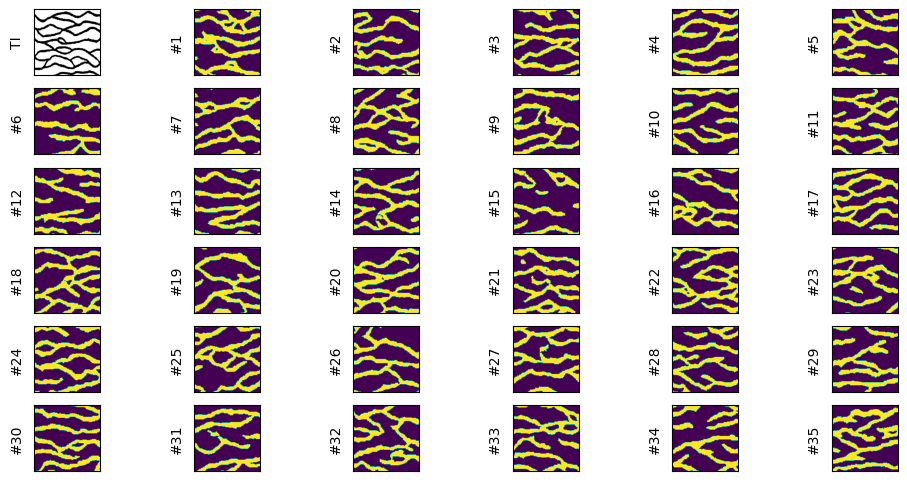

In [9]:
plt.figure(figsize=(12,6))
plt.subplot(6,6,1)
plt.imshow(training_image, cmap='binary')
plt.xticks([]); plt.yticks([]); plt.ylabel('TI')
for i in range(2,37):
    plt.subplot(6,6,i)
    plt.imshow(realizations[i])
    plt.ylabel('#{}'.format(i-1))
    plt.xticks([]); plt.yticks([])
plt.show();

In [81]:
# Randomly generate train-test indices
split_perc = (7/10)
train_size = int(np.ceil(realizations.shape[0] * split_perc))
test_size  = int(np.floor(realizations.shape[0] * (1-split_perc)))

train_idx = np.random.choice(realizations.shape[0], size=train_size, replace=False)
test_idx  = np.setdiff1d(np.arange(realizations.shape[0]), train_idx)

# Train/Test split
X_train = realizations[train_idx,:,:]
X_test  = realizations[test_idx,:,:]

# Flatten
X_train_f = X_train.reshape(X_train.shape[0], 128*128)
X_test_f  = X_test.reshape(X_test.shape[0], 128*128)

print('X_train shape:      {} | X_test shape:       {}'.format(X_train.shape, X_test.shape))
print('X_train_flat shape: {}    | X_test_flat shape:  {}'.format(X_train_f.shape, X_test_f.shape))

X_train shape:      (350, 128, 128) | X_test shape:       (150, 128, 128)
X_train_flat shape: (350, 16384)    | X_test_flat shape:  (150, 16384)


***

#### Model Generation (via CNN-compression-reconstruction)

In [82]:
def conv_block(input, filt, act, pads='same'):
    x = Conv2D(filt, (3,3), padding=pads, activation=act)(input)
    #x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    return x

def convT_block(input, filt, act, pads='same'):
    x = Conv2D(filt, (3,3), padding=pads, activation=act)(input)
    #x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    return x

def latent_block(input, zdim, act):
    shape_before_flatten = keras.backend.int_shape(input)[1:]
    x = Flatten()(input)
    enc = Dense(zdim, activation=act)(x)
    x = Dense(np.prod(shape_before_flatten))(enc)
    x = Reshape(shape_before_flatten)(x)
    return x, enc

def make_autoencoder(act='relu'):
    keras.backend.clear_session()
    inp = Input(shape=(128,128,1))
    x = conv_block(inp, 4,   act)
    x = conv_block(x,   16,  act)
    x = conv_block(x,   64,  act)
    x = conv_block(x,   128, act)
    x, enc = latent_block(x, 8, act)
    x = convT_block(x,  128, act)
    x = convT_block(x,  64,  act)
    x = convT_block(x,  16,  act)
    x = convT_block(x,  4,   act)
    out = Conv2D(1, (3,3), padding='same')(x)
    ae_model = Model(inp, out)
    enc_model = Model(inp, enc)
    return ae_model, enc_model

In [96]:
cnn_model, cnn_encoder = make_autoencoder(act='selu')
print('Number of parameters: {:,}'.format(cnn_model.count_params()))

Number of parameters: 454,265


Training time: 0.64 minutes


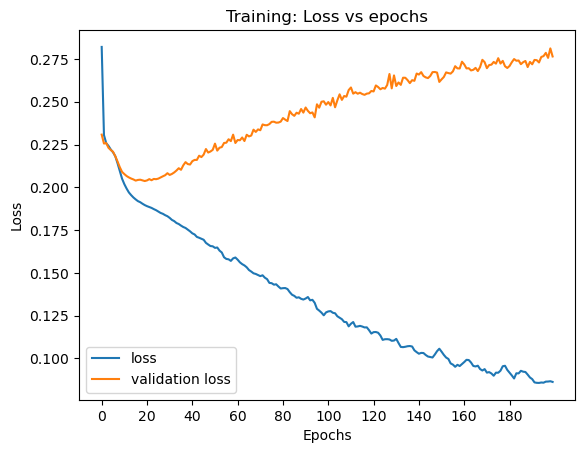

In [97]:
# compile model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
cnn_model.compile(optimizer  = opt,
                    loss     = 'mse', 
                    metrics  = ['mse'])

# fit model
start = time()
fit = cnn_model.fit(X_train, X_train,
                    shuffle          = True, 
                    epochs           = 200, 
                    batch_size       = 40, 
                    validation_split = 0.25,
                    verbose          = 0)
train_time = time()-start
print('Training time: {:.2f} minutes'.format(train_time/60))
plot_loss(fit)

In [98]:
# Latent space predictions
z_train_pred = cnn_encoder.predict(X_train).squeeze().astype('float64')
z_test_pred  = cnn_encoder.predict(X_test).squeeze().astype('float64')

5/5 [==============================] - 0s 3ms/step


In [99]:
# train/test predictions
train_pred = cnn_model.predict(X_train).squeeze().astype('float64')
test_pred  = cnn_model.predict(X_test).squeeze().astype('float64')

train_pred_f = train_pred.reshape(train_pred.shape[0],-1)
test_pred_f  = test_pred.reshape(test_pred.shape[0],-1)

train_error = X_train - train_pred
test_error  = X_test  - test_pred

mse_train, ssim_train = image_mse(X_train, train_pred), image_ssim(X_train, train_pred)
mse_test, ssim_test   = image_mse(X_test, test_pred), image_ssim(X_test, test_pred)

print('Training - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_train, ssim_train))
print('Testing  - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_test, ssim_test))

5/5 [==============================] - 0s 6ms/step


c:\ProgramData\Anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Training - MSE: 0.134 | MSSIM: 1.000
Testing  - MSE: 0.279 | MSSIM: 1.000


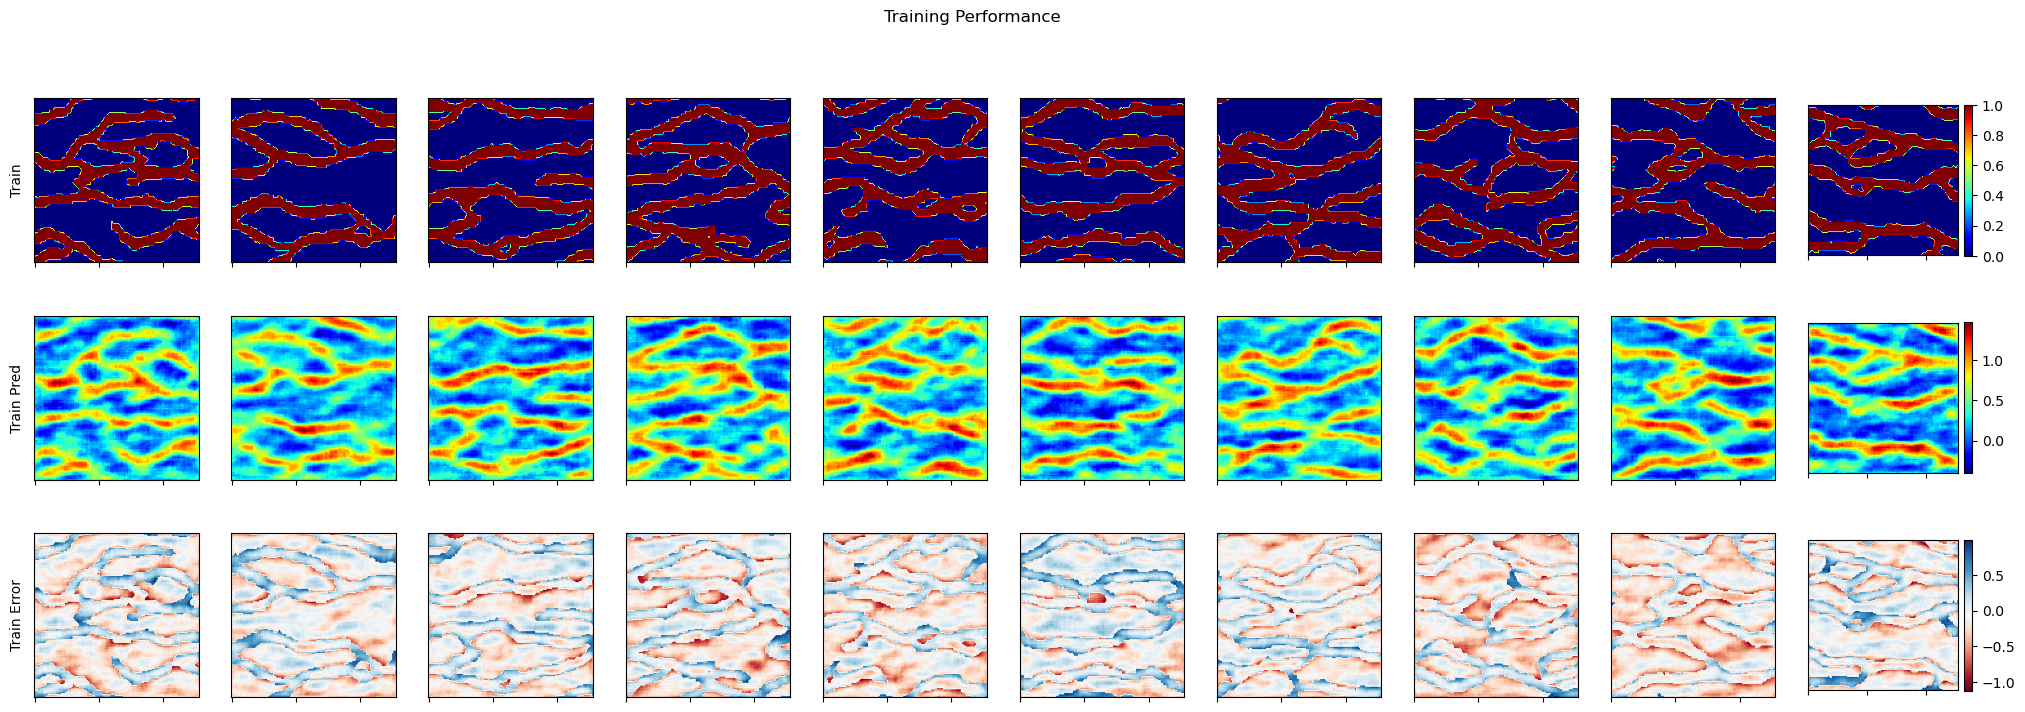

In [100]:
# visualize TRAIN results
train_performance = [X_train, train_pred, train_error]
train_labels      = ['Train', 'Train Pred', 'Train Error']
plot_results(train_performance, train_labels, suptitle='Training Performance')

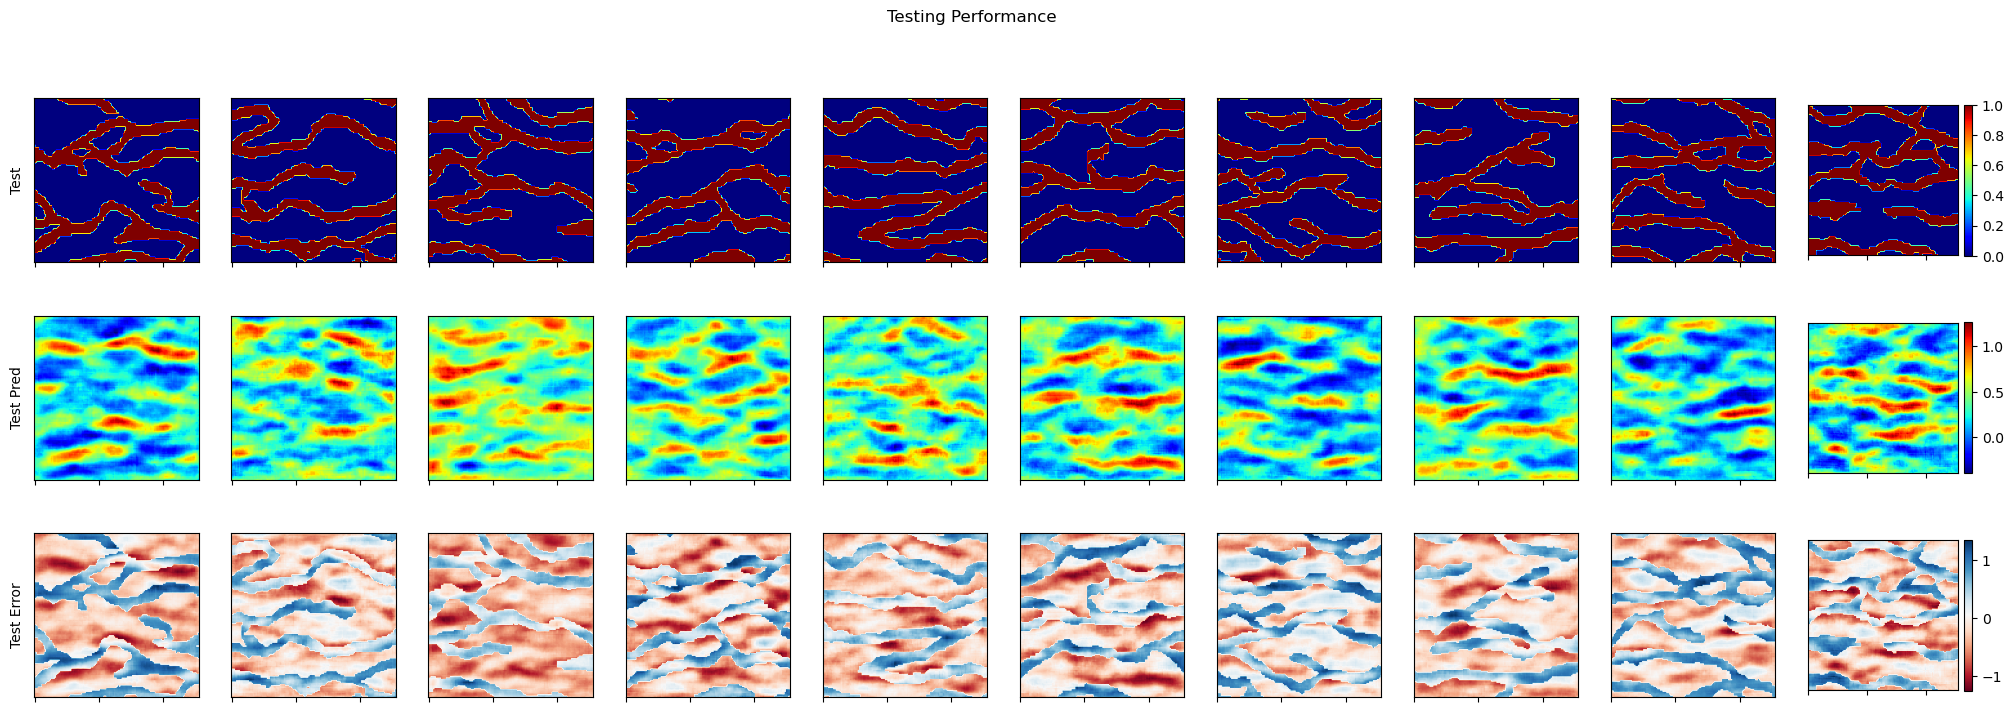

In [101]:
# visualize TEST results
test_performance = [X_test, test_pred, test_error]
test_labels      = ['Test', 'Test Pred', 'Test Error']
plot_results(test_performance, test_labels, suptitle='Testing Performance')

***

#### Manifold Learning

In [66]:
#distance_metrics = ['cityblock', 'cosine', 'euclidean', 'haversine', 'l1', 'l2', 'manhattan', 'nan_euclidean']

In [89]:
# t-Distributed Stochastic Neighbord Embedding
tsne            = TSNE(n_components=2, metric='euclidean', learning_rate='auto', init='random')
tsne_train      = tsne.fit_transform(X_train_f)
tsne_test       = tsne.fit_transform(X_test_f)
tsne_train_pred = tsne.fit_transform(train_pred_f)
tsne_test_pred  = tsne.fit_transform(test_pred_f)
print('t-SNE shape: {}'.format(tsne_train.shape))

t-SNE shape: (350, 2)


In [90]:
# Multidimensional Scaling
mds            = MDS(n_components=2, dissimilarity='euclidean')
mds_train      = mds.fit_transform(X_train_f)
mds_test       = mds.fit_transform(X_test_f)
mds_train_pred = mds.fit_transform(train_pred_f)
mds_test_pred  = mds.fit_transform(X_test_f)
print('MDS shape: {}'.format(mds_train.shape))

MDS shape: (350, 2)


In [91]:
# Isomap Embedding
isomap            = Isomap(n_components=2, metric='euclidean')
isomap_train      = isomap.fit_transform(X_train_f)
isomap_test       = isomap.fit_transform(X_test_f)
isomap_train_pred = isomap.fit_transform(train_pred_f)
isomap_test_pred  = isomap.fit_transform(test_pred_f)
print('Isomap shape: {}'.format(isomap_train.shape))

Isomap shape: (350, 2)


In [92]:
# Locally Linear Embedding
lle            = LocallyLinearEmbedding(n_components=2, method='standard')
lle_train      = lle.fit_transform(X_train_f)
lle_test       = lle.fit_transform(X_test_f)
lle_train_pred = lle.fit_transform(train_pred_f)
lle_test_pred  = lle.fit_transform(test_pred_f)
print('Locally Linear Embedding shape: {}'.format(lle_train.shape))

Locally Linear Embedding shape: (350, 2)


In [93]:
# Spectral Embedding
spectral            = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
spectral_train      = spectral.fit_transform(X_train_f)
spectral_test       = spectral.fit_transform(X_test_f)
spectral_train_pred = spectral.fit_transform(train_pred_f)
spectral_test_pred  = spectral.fit_transform(test_pred_f)
print('Spectral Embedding shape: {}'.format(spectral_train.shape))

Spectral Embedding shape: (350, 2)


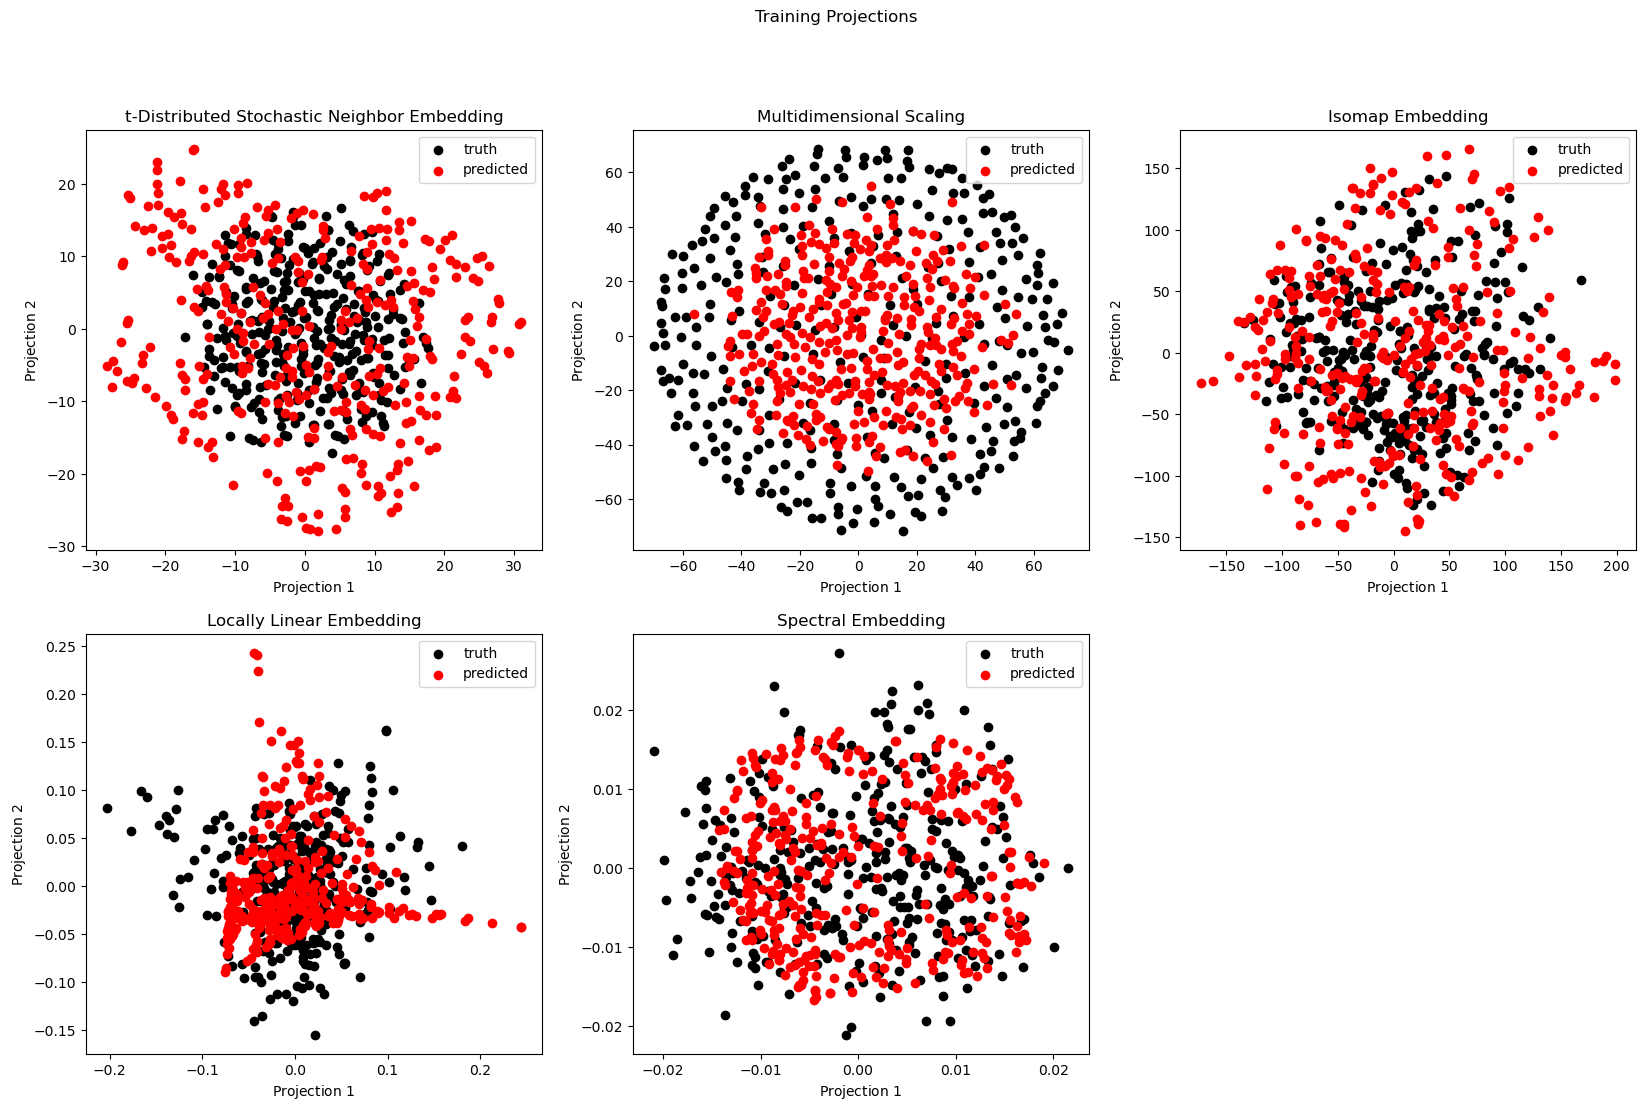

In [94]:
manifold_train      = [tsne_train, mds_train, isomap_train, lle_train, spectral_train]
manifold_train_pred = [tsne_train_pred, mds_train_pred, isomap_train_pred, lle_train_pred, spectral_train_pred]

plt.figure(figsize=(20,12), facecolor='white')
plt.suptitle('Training Projections')
for i in range(5):
    plt.subplot(2,3,i+1)
    plot_manifold(manifold_data=manifold_train[i], manifold_pred=manifold_train_pred[i], title=manifold_titles[i])

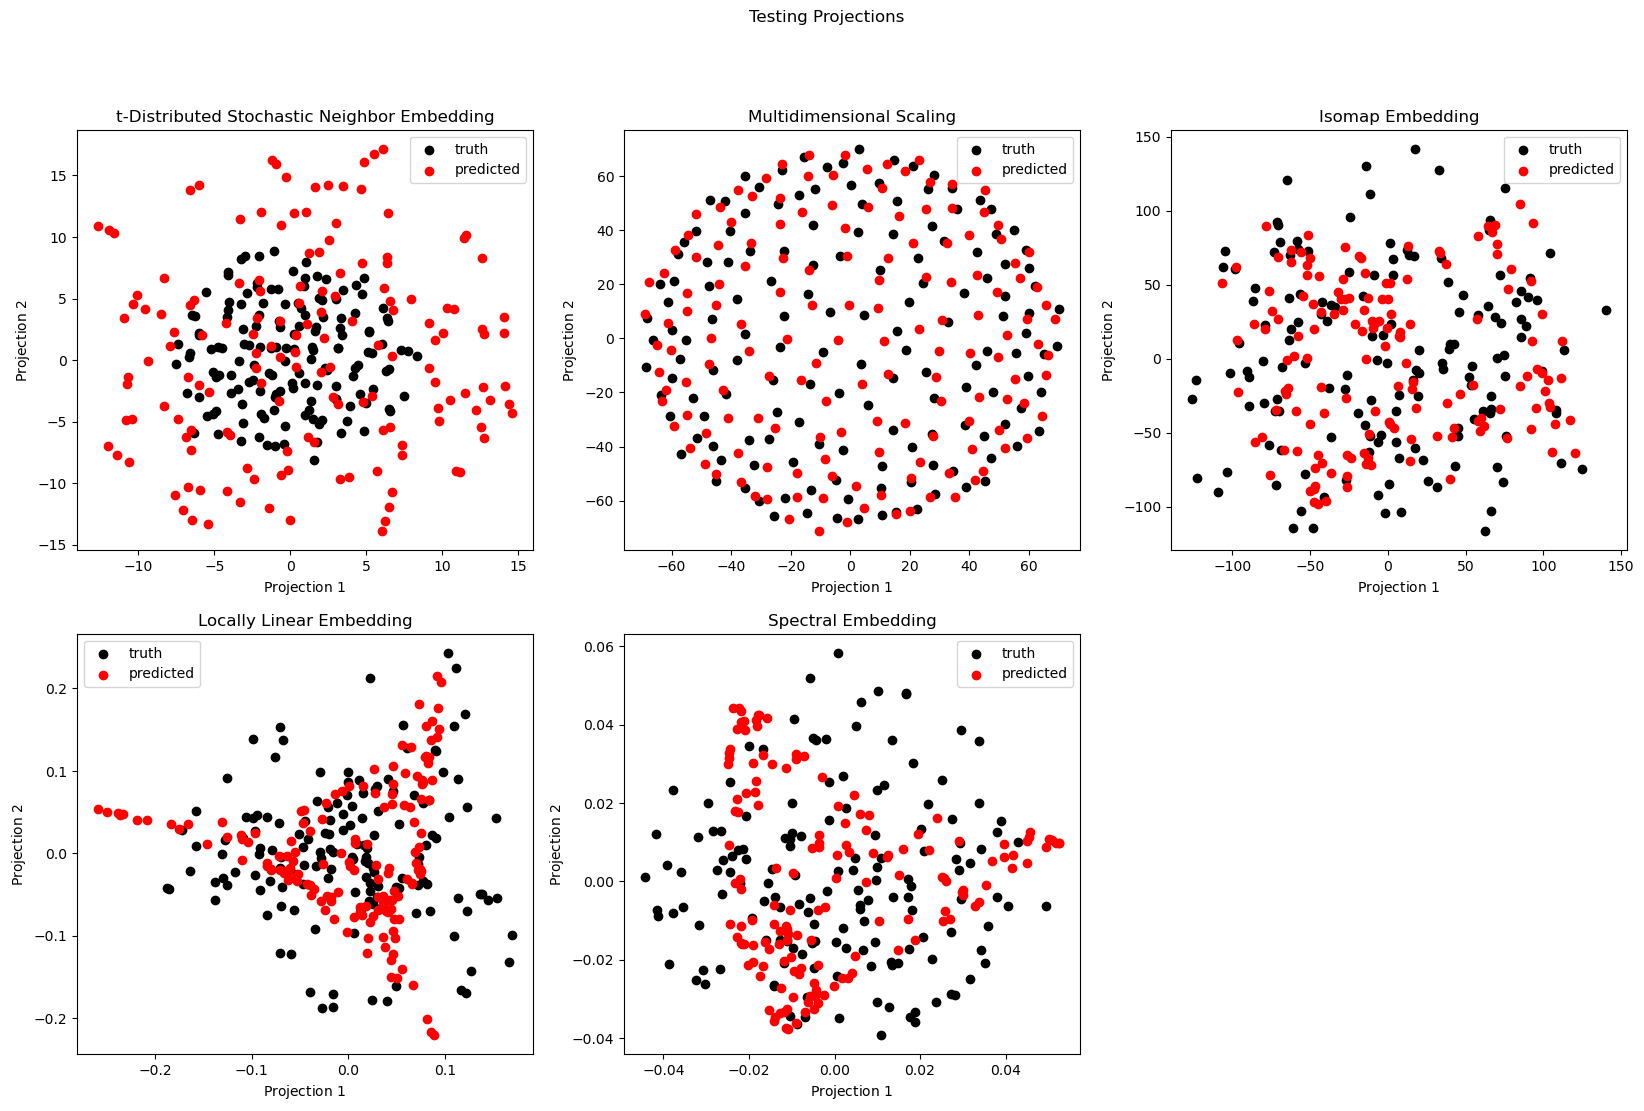

In [95]:
manifold_test      = [tsne_test, mds_test, isomap_test, lle_test, spectral_test]
manifold_test_pred = [tsne_test_pred, mds_test_pred, isomap_test_pred, lle_test_pred, spectral_test_pred]

plt.figure(figsize=(20,12), facecolor='white')
plt.suptitle('Testing Projections')
for i in range(5):
    plt.subplot(2,3,i+1)
    plot_manifold(manifold_data=manifold_test[i], manifold_pred=manifold_test_pred[i], title=manifold_titles[i])

***
# END